<h1> Local Blackbox Explanation Methods</h1>

Welcome, here you will be introduced to and gain experience in using some more methods of explaining black box models. In the last lab we looked at model agnostic global explanation methods for tabular data. This week you will take a look at a local explanation method for image data that is also model agnostic. You will use a complex pre-trained ML model to detect and label objects in images. In this lab we will take a deep dive into the code to implement the Randomized Input Sampling for Explanation (RisE) method. Since there is no library, and it is feasible to code it from the explanation in the published paper - you will implement RISE in this workbook.

<h2>Learning Objectives:</h2>

- Gain experience in implementing and using local Blackbox algorithm explanation techniques.
 - specifically RisE 
- To investigate gaining local insights into Blackbox decision making algorithms.
 - specifically object labeling from images 
- To critically appraise this technique in its use and limitations in explaining blackbox algorithms.

<h3>Local Explanations</h3>

In this lab we will focus an example outcome explanation method as described in [1]. Specifically we will use one that works on image data:

- RisE - Randomized Input Sampling for Explanation [2].

<center><img src="images/blackbox_outcome.png" style="width:800px;"></center>
<caption><center> <i><b>Figure 1:</b> Blackbox local outcome explanation</i></center></caption>

    
[1] R. Guidotti, A. Monreale, S. Ruggieri, F. Turini, D. Pedreschi, and F. Giannotti, “A Survey Of Methods For Explaining Black Box Models,” ACM Comput. Surv., Feb. 2018. https://dl.acm.org/doi/10.1145/3236009

[2] V. Petsiuk, A. Das, and K. Saenko, “RisE: Randomized input sampling for explanation of black-box models,” Br. Mach. Vis. Conf. 2018, BMVC 2018, vol. 1, 2019.https://arxiv.org/abs/1806.07421
    
Run the following cell to import libaries needed for this workbook


In [1]:
import sys
import os
import tensorflow as tf
from platform import python_version 


#------------- Load in some helpful packages we will use for the lab -------------------------

import matplotlib.pyplot as plt
from skimage.transform import resize   #ERROR HERE COMMENT OUT
%matplotlib inline

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np # linear algebra


#------------- Print versions an paths for potencial debugging -------------------------

print('Python version:', python_version()) # print the version of python the script is using
print('Python path:', sys.executable) # print the path for the python executable the script is using
print('Working Directory:', os.getcwd()) # print the current working directory 
print ("TensorFlow version: " + tf.__version__) # print the tensorflow version


Python version: 3.7.4
Python path: /Users/Andy/opt/anaconda3/bin/python
Working Directory: /Users/Andy/Developer/Swansea Uni/CDT/Semester 2/CSCM21 - Abuses, Biases and Blessing of Data/CSCM21 - Abuses, Biases and Blessing of Data/Labs/Lab 3/Local Black Box Explanations Lab
TensorFlow version: 2.3.1


<h1> 1. Object Classification in Images</h1>

As we are treating the models as a Blackbox we will download a pre-existing image object labeling model called ResNet50 this is a pre-trained model based on a CNNs architecture presented by He <i>et al</i> in [3]. Specifically this is a 50 layer residual net and has a total of 23,521 parameters, it is not the focus of this workbook to understand this model architecture, the figure below is for reference and to place into context the model complexity.

[3] K. He, X. Zhang, S. Ren, and J. Sun, “Deep residual learning for image recognition,” Proc. IEEE Comput. Soc. Conf. Comput. Vis. Pattern Recognit., vol. 2016-December, pp. 770–778, 2016. https://arxiv.org/abs/1512.03385

<center><img src="images/resnet_kiank.png" style="width:850px;height:150px;"></center>
<caption><center> <i><b>Figure 2:</b> ResNet-50 model Architecture</i></center></caption>



    
<h2> 1.1 Load the Pre-Trained Blackbox Model an Image Object Classifier, $f$.</h2>
    
**You tasks are to:**
    
- set the height, $H$, and width, $W$, of the image in variables `IMG_HEIGHT` and `IMG_WIDTH`
- load the ResNet50 model and save it in variable `f_restnet`. The following code loads the ResNet50 model where $H$ and $W$ are height and width of the image, and $ch$ the number of channels. In a colour image there are three channels i.e. Red, Green and Blue.
    
```python
resnet50.ResNet50(weights='imagenet', input_shape=(H,W,ch))
```
<b>Hint:</b> ResNet50 requires images to be 224 x 224 pixels in order to classify them. 

<b>Note:</b> it might take a few seconds to download the model. 

In [2]:
# Step 1: set height and width of images
### START CODE HERE ###
IMG_HEIGHT = 224  # H
IMG_WIDTH = 224   # W
### END CODE ###

# Step 2: load ResNet50 Model
### START CODE HERE ###
#f_restnet = ResNet50(weights='imagenet')

f_restnet = ResNet50(weights='imagenet') 
### END CODE ###

f_restnet.summary() # prints the model architecture to the screen

[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 14, 14, 256)  0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 14, 14, 256)  590080      conv4_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 14, 14, 256)  0           conv4_block1_2_bn[0][0]   

<h2>1.2 Load an Image, $I$, for Inference</h2>
    
In this section you will need to load an image to test the ResNet model and its ability to detect objects in an image. Moreover, we will have to do a bit of pre-processing in order that the image can be fed into the model. We will need to save the input into a 4D tensor (4D array) as this is the type of input the model requires. the first thre dimentnion relate to the way images are save in arrays and these three dimention are fixed for the Resnet model at 224x224x3 this is illustrated in Figure 3. The final dimention relates to the number of input images which can range from one to many.

<center><img src="images/3D_ImageTensor.png" style="width:418px"></center>
<caption><center> <i><b>Figure 2:</b>Image Saved as 3D tensor (Numpy Array)</i></center></caption>

**You will need to:**

- load an image, $I$, from file (jpg format) into `original_image`.
  - intially use the Cat_dog image contained in images direcrory from the zip file download
  - You can play with various images later in the lab.
- run the code to do some pre-processing on the image, pre-processing steps already coded are:
  - re-size the image to fit into model, saved in `resize_image`
  - convert the PIL (resized) image (width, height) to a NumPy array (height, width, channel) saved in `numpy_image`.
  - Convert the image array into 4D Tensor (samples, height, width, channels), saved in  `input_image_tensor`
    - The 4D image tensor can take multiple 3ch images
- print the size of the image input vairables
  
**Hint**

- use `image.load_img()` to load an image in PIL format, this is a liabry from Keras imported at th etop of the workbook. [Link to help](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/load_img)
- When the image data is in PIL format then use `image.size` this is equliavalent to `image.shape` which you will need to use when the image data is in Numpy array format.

<b>Note:</b> 



In [3]:
cwd = os.getcwd()
print(cwd)

/Users/Andy/Developer/Swansea Uni/CDT/Semester 2/CSCM21 - Abuses, Biases and Blessing of Data/CSCM21 - Abuses, Biases and Blessing of Data/Labs/Lab 3/Local Black Box Explanations Lab


In [8]:
### START CODE HERE ###

#1: save file name and path
filename = cwd

#2. load an image in PIL format
original_image = image.load_img(cwd + "/images/Cat_Dog.jpg")

### END CODE ###

#re-size image to fit into model - PIL format
resize_image = original_image.resize((IMG_HEIGHT, IMG_WIDTH), resample=0)

# convert the PIL image (width, height) to a NumPy array (height, width, channel)
numpy_image = image.img_to_array(resize_image) 

# Convert the image array into 4D Tensor (samples, height, width, channels) by adding an extra dimension to the axis 0.
input_image_tensor = np.expand_dims(numpy_image, axis=0)

# create proccesed copy of the input image for resnet50
processed_image = preprocess_input(input_image_tensor.copy())     #######   NOTE TO SELF WHY IS THIS USED???


### START CODE HERE ###

#3. Print the size/shape of the image data at each stage of the pre-processing
print("Original image size and shape = ", original_image.size)
print("Resized image size and shape = ", resize_image.size)
print("NumPy image size and shape = ", numpy_image.shape)
print("Input tensor size and shape = ", input_image_tensor.shape)
print("Processed Input tensor size and shape = ", processed_image.shape)

### END CODE ###

Original image size and shape =  (300, 168)
Resized image size and shape =  (224, 224)
NumPy image size and shape =  (224, 224, 3)
Input tensor size and shape =  (1, 224, 224, 3)
Processed Input tensor size and shape =  (1, 224, 224, 3)


##### **Expected Output**:

<table>
    <tr>
        <td>
            original_image
        </td>
        <td>
            (300, 168)
        </td>
    </tr>
    <tr>
        <td>
            resize_image
        </td>
        <td>
            (224, 224)
        </td>
    </tr>
    <tr>
        <td>
            numpy_image
        </td>
        <td>
            (224, 224, 3)
        </td>
    </tr>
    <tr>
        <td>
            input_image_tensor 
        </td>
        <td>
            (1, 224, 224, 3)
        </td>
    </tr>
    <tr>
        <td>
            processed_image 
        </td>
        <td>
            (1, 224, 224, 3)
        </td>
    </tr>
</table>


You can see that the image PIL is in the format of $height$ x $width$, the NumPy array is in the format $height$ x $width$ x $channels$ and the final image is in the format $number\_images$ x $height$ x $width$ x $channels$. Finally the 4D tensor is pre-processed (saved in more compresse format) and saved in `processed_image` to be passed into the model, $f$, for classification.


<h2>1.3 Display the Processed Input Image, $I$</h2>

Moving forward in the note book we will use two image input varibles, both variable are 4D tensors:
- The first `processed_image` will be passed to the model for classifcation
- the second `input_image_tensor` is sessinally excalty the same data as in `processed_image` only saved in a differnet format (on disk) we use this variable if we want to see or visulaise the data.

**Your task is to:**

- Print the shpae of the **first** image in the 4D tensor `input_image_tensor`.
  - i.e. slice into the first location in the first dimention of the array and use `.shape`
- display the data at that location in the array to the screen (in image format)
  -  again using the same slice notation as above to access the image data. 

input_image_tensor[0] shape (224, 224, 3)


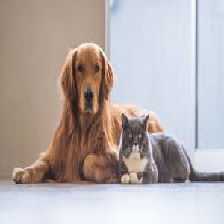

In [9]:
####  START CODE ######

#1. print the shape of the first image data in the array.
print('input_image_tensor[0] shape',input_image_tensor[0].shape) 


#2. visualize a sample image 
image.array_to_img(input_image_tensor[0])

#### END CODE ####

##### **Expected Output**:

<table>
    <tr>
        <td>
            input_image_tensor[0] shape
        </td>
        <td>
            (224, 224, 3)
        </td>
    </tr>
    <tr>
        <td>
            image data displayed
        </td>
        <td>
            <center><img src="images/resize_cat_dog.png" style="width:224px"></center>
        </td>
    </tr>
</table>






<h2>1.4 Classify the Image, $I$, with the model, $f$.</h2>

When you classify the image using the ResNet50 model it returns the classification score for all 1,000 labels at the same time.

**Your tasks are to:**

- Classify the objects in the image using the downloaded ResNet50 model.
- Decode the results from Resnet 'predictions_resnet50' by runing
  - After running the code once to see the top 5 labels explore the top 10, top 20 and all 1000 labels.

<b>Hint:</b> 

- The code `f_restnet.predict(I)` predicts labels, where $I$ is the <b>processed</b>. Rememer the input image for the resnet callsifier was saved in the variable `processed_image` in a previous cell. 
-  `decode_predictions()`  returns a list of the top $n$, object lables from resent predictions, [Link to help](https://keras.io/applications/#classify-imagenet-classes-with-resnet50).


<b>Note:</b> it might take a few seconds for the code to run.

In [5]:
### START CODE ###

#1: predict ojects in image using resenet
predictions_resnet50 = f_restnet.predict(processed_image)

#2: investigate top 10 and top 20 lables
label_resnet50 = None
### END CODE ###

print ("label_resnet50 = ", label_resnet50)

label_resnet50 =  [[('n02100877', 'Irish_setter', 0.3729028), ('n02099601', 'golden_retriever', 0.35452566), ('n02088094', 'Afghan_hound', 0.11604074), ('n02091831', 'Saluki', 0.075002454), ('n02102318', 'cocker_spaniel', 0.062313735)]]


<h1>3. Explaining Model Classifications using Randomized Input Sampling for Explanation (RisE)</h1>


In this section you will explore a method applied to image classification explanation introduced Petsiuk <i>et al</i> in [2]  Specifically an approach called RisE (Randomized Input Sampling for Explanation) that generates a salience map indicating the <b>importance</b> of each pixel's contribution to the model’s prediction.

This is achieved by once again treating the model as a black box and only using the inference process. As can be seen in the figure below an image, $I$, is multiplied pixel-wise by a mask, $M_i$, resulting in several masked image $I \odot M_i$. This  then passed through the model inference, $f$, and classification score for a given label is recored. This is done several times with randomly varied masks, $M_i$, each time recording the classification score. These scores are combined with their respective masks, $M_i$ using a weighted average to generate the salience map, $S$. The higher the score for each pixel in the salience map the more that pixel is used in the inference of that given classification. 


<center><img src="images/RisE_Diagram.png" width="800px"/></center>
<caption><center> <i><b>Figure 1:</b> RisE Architecture </i></center></caption>


[2] V. Petsiuk, A. Das, and K. Saenko, “RisE: Randomized input sampling for explanation of black-box models,” Br. Mach. Vis. Conf. 2018, BMVC 2018, vol. 1, 2019.https://arxiv.org/abs/1806.07421

<h2>2.1 Mask Generation, $M_i$.</h2>

In this section you will need to generate a number of binary masks, $M_i$. Below are instructions (edited from the paper) on how to generate the masks you will need to edit code in the following sections to implement RisE illustrated in Figure 1.

<b>Taken from the paper:</b>

1. Create $N$ binary masks of size $h×w$ (smaller than image size $H × W$) by setting each element independently to 1 with probability $pl$ and to 0 with the remaining probability.

2. Up-sample all masks to size $(h+1)CH \times (w+1)CW$ using bilinear interpolation, where $CH \times CW = \frac{H}{h} \times \frac{W}{w}$ is the size of the cell in the up-sampled mask.

3. Crop areas $H \times W$ with uniformly random indents from (0,0) up to (CH,CW).

<b>End of paper quote</b>

Where above: $h$ and $w$ refer to height and width of masked grid;  $H$ and $W$ refer to height and width of input image; $CH$ and $CW$ refer to height and width of cell-size meaning the number pixels in the input image that are covered by a single pixel in the grid mask. i.e.  $CH = \frac{H}{h}$ and  $CW = \frac{W}{w}$.

<h3>2.1.1 Generating Small Random Grids</h3>

Over the coming sections we will break these three steps down. In the following cell you will create an array of $N$ grids (first step to masks) this will result in a 3D array. 2D mask and the third dimeantioin so we can save all the masks generated in the same array.

**Your Tasks are to:**

- Set the values for the variables:
  - `N`, the number of masks, try 1000.
  - The height, $h$ and width, $w$, of the mask, in variable `s`, set this to 8
  - Set the probabaility of each pixel in the 8 x 8 masks, $M$, being a zero or one to be equal, i.e. $pl = 0.5$
- Generate an array of $N$ grids each $h \times w$ containing random 0s and 1s where the likelihood of each element bing a 1 is 0.5.
- Print the size of the grid array `grid`.
- Finally Check that the proabailty with which each pixel in the grids is set to a 1 approximates to 0.5.

<b>Hint:</b> 

- `np.random.rand()` can generate an array of a given size with random numbers between 0 and 1, [Link to help](https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html)



In [18]:

### START CODE ###
#1: Set the varible for number of masks, size of grid and proabaility of grid pixel being 1
N = 1000 # set numer of binary masks
s = 8   # set the size of the mask value for h & w 
pl = 0.5  # set probability of each element from in the mask being a one

#2. Create N grids of size s x s containing random 0's and 1's with equal proability.
grid = np.random.randint(low=0, high=2, size=(N, s, s))

#3. Print the shape of the 3D array generated.
print("Size of grid array: ",grid.shape)

### END CODE ###

unique, counts = np.unique(grid, return_counts=True)
p =  counts[1] / sum(counts)
print("probability of ones acieved = ",p)


Size of grid array:  (1000, 8, 8)
probability of ones acieved =  0.500234375


##### **Expected Output**:

<table>
    <tr>
        <td>
            Size of grid array
        </td>
        <td>
            (1000, 8, 8)
        </td>
    </tr>
    <tr>
        <td>
            probability of ones acieved
        </td>
        <td>
            <i>Value approching 0.5 ( will be random)</i>
        </td>
    </tr>
</table>

Run the cell below to take a look at one of the 8 x 8 grids.

**Your task is to**

- print the shape of the first position in the grid `grid[0]`
- change the `grid[index]` to take a look at different grids in your array of randomly generated grids

(8, 8)


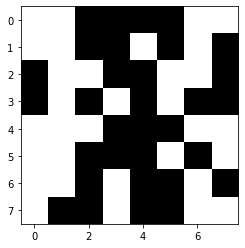

In [22]:
### START CODE ###

#1. print size of the first grid in the arrayof grids
print(grid[0].shape) 

# change the gird to be viewed to see if they are all random and different.
plt.gray()
plt.imshow((grid[3]))

### END CODE ###


<h3>2.1.2 Change the Random Grids into Masks</h3>

In this section we need to take the grids and use them to generate masks, $M_i$. The masks need to be the same size as the input image. 

**You will need to:**
    
- Create an empty array `M_i` to hold $N$ masks each with a resolution of the processed input image.   
- Print the shape of the array `M_i` you have created to check it is the right dimensions. 

<b>Hint:</b>

- `np.empty()` gernates an empty Numpy array of a given size. [Link to help](https://numpy.org/doc/stable/reference/generated/numpy.empty.html)

<b>Note:</b> the code then up-sizes the grid to full input image resolution (with shifting to make the mask more random as described in steps 2 & 3 in the paper).


In [23]:
grid = grid.astype('float32')

### START CODE ###

#1: create array and print shape of array
M_i = np.empty(shape=(N, IMG_HEIGHT, IMG_WIDTH))

#2. Print size of array
print("masks shape", M_i.shape)

### END CODE ###

# Calucate cell size
cell_size = np.ceil(np.array((IMG_HEIGHT,IMG_WIDTH)) / s)
up_size = (s + 1) * cell_size

for i in range(N):
    # Random shifts
    x = np.random.randint(0, cell_size[0])
    y = np.random.randint(0, cell_size[1])
    # Linear upsampling and cropping
    M_i[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect', anti_aliasing=True)[x:x + IMG_HEIGHT, y:y + IMG_WIDTH]


masks shape (1000, 224, 224)


##### **Expected Output**:

<table>
    <tr>
        <td>
            masks shape
        </td>
        <td>
            (1000, 224, 224)
        </td>
    </tr>
</table>

<h3> 2.1.3 View Generated Masks, $M_i$</h3>

In finally for mask gerneation you will view examples of the the full size masks, $M_i$.

**Youor task is to:**

- View examples of the masks gernated in the array `M_i`.
    - when you have run it once investigate other masks by changing the index in M_i[index].
    
**Hint** use the same style of code as used to view the `grid[0]` examples.

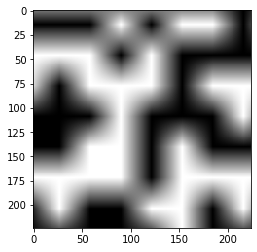

In [24]:
### START CODE ###

plt.gray()
plt.imshow((M_i[0]))

### END CODE ###

<h2>2.2 Combine Masks and Original Image, $I \odot M_i$</h2>

In this section you will need to create $N$ versions of the input image each one masked by one of the random masks, $M_i$.  Note since the input image , $I$ has three channles the code reshpaes the `M_i` array to contant the same number of dimentions as the 4D input_image_tensor.

**Your task is to:**

- print the shape of the `M_i` array
- multiply (pixelwise) the masks with the input image i.e. $I \odot M_i$
- print the shape of the resutlant maked images `masked`.

Note: the shape of the masksd image array, $I \odot M_i$, should be $N \times H \times W \times ch$ i.e. 1000 x 224 x 224 x 3.

In [25]:
M_i = M_i.reshape(-1, IMG_HEIGHT,IMG_WIDTH, 1)

### START CODE ###
#1. Print shape of M_i
print("shape of  M_i ", M_i.shape)

#2: pixelwise multiplication the masks and the input image 
masked = M_i * input_image_tensor

#print shape of masked images
print("Masked Images", masked.shape)

### END CODE ###


shape of  M_i  (1000, 224, 224, 1)
Masked Images (1000, 224, 224, 3)


##### **Expected Output**:

<table>
    <tr>
        <td>
            shape of  M_i
        </td>
        <td>
            (1000, 224, 224, 1)
        </td>
    </tr>
    <tr>
        <td>
            Masked Images
        </td>
        <td>
            (1000, 224, 224, 3)
        </td>
    </tr>
</table>



<h3>2.2.1 Investigate the Different Masked Images and Classification Labels</h3>

In this section you will run a given masked image through the classifier model, $f$, and get the score for a given class. You will need to:

- Set $test\_image$ to one of the masked images. <b>Hint:</b> use code below where index ranges from 0 to $N$ each referring to a different masked image.

```python
masked[index]```

- Insert the line that runs the classifier, $f$, and run the code. The code to classify and image is below where $I$ is the image being classified i.e. $test\_image$.
```python
f_restnet.predict(I)```

- Change the test image for different masked image and rerun the, notice the difference in the classification label confidence.
- Change the classification label using the number ID and run code.

Note: you will need to use the look-up table provided here: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a in order to find out the number ID for the label you would like to investigate.

Explore a number of input masked images and classification labels, notice the label confidence changing with different masked inputs. 

40960/35363 [==================================] - 0s 1us/step
Classification confidence for class German_shepherd is:  [1.6073376e-06]


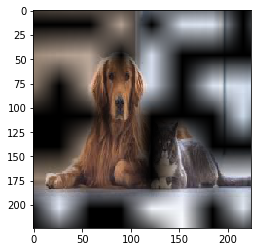

In [26]:
#Step 2: change input image
### START CODE ###
test_image = masked[0]
### END CODE ###

plt.imshow(np.uint8(test_image))
test_image = np.expand_dims(test_image, axis=0)

def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

#Step 1: insert code that runs classifier
### START CODE ###
pred_test_image = f_restnet.predict(test_image)
### END CODE ###

#Step 3: change class label
### START CODE ###
class_label = 235 # Need to be changed?
### END CODE ###

print("Classification confidence for class", class_name(class_label),"is: ",pred_test_image[:,class_label])



<h2>2.3 Run Classifier for All Masked Images</h2>
    
Run the code below to classify all masked images with all labels.
    
<b>Note:</b> this may take several seconds (possibly couple of minutes) to run.

In [27]:
batch_size = 100

preds = []
# Make sure multiplication is being done for correct axes

for i in range(0, N, batch_size):
    preds.append(f_restnet.predict(masked[i:min(i+batch_size, N)]))
preds = np.concatenate(preds)


In [28]:
preds.shape

(1000, 1000)

<h3>2.3.1 Calculate Salient Map using Weighted Average</h3>



<b>Note:</b> when the salience is displayed over the image a colour scheme (called jet) is used to illustrate the importance of each pixels contribution to the given Classification. This colour scheme is illustrated below where the left/blue side is least important and the right/red is most important.

<center><img src="images/jet_colour.png" style="width:400px"></center>
<caption><center> <i>Jet Colour Range (Left/Blue Least, Right/Red Most)</i></center></caption>

- run the code below to calculate the weighted average.

In [29]:
sal = preds.T.dot(masked.reshape(N, -1)).reshape(-1, IMG_HEIGHT,IMG_WIDTH)
sal = sal / N / pl

<h3>2.3.2 Plot the Salience Map Over the Input Image</h3>

You will need to:

- run the code to plot the salience map
- change the classification label and plot the map again, investigate several classification labels

Human readable classification codes https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
    

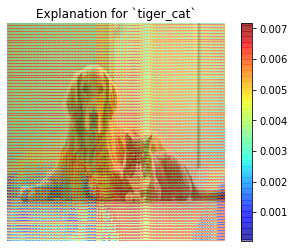

In [30]:
#Step 1: change class label code
### START CODE ##
class_idx = 282
### END CODE ###

plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(np.uint8(input_image_tensor[0]))
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

<h1>3. Investigate Saliance maps for ten image of your choice</h1>
    
In this section you will need to re-run the code in section 2.3 to calualte and view the saliance mapes for five input images of your choice. **Note** remember also to run the pre-proceeing steps on the input images.
    
**Your task is to:**

- To print two saliance maps for five differents images for two classes each one that make sence (obejct or simpular object is in the image) and one that does not (object cleary not in the image).

In [ ]:
### START CODE ##




### END CODE ###

In [ ]:
### START CODE ##




### END CODE ###

<h1>4. Critical Analysis, Reflection & Discussion</h1>

- Why does the RisE method start with small grid of 8 x 8 and not simply generate randomized masks at full size?
- Does sailence relate to absolute classification confidence?

- How does the RisE method fair in the following criteria for model explanations:
    - Interpretability
    - Accuracy
    - Fidelity
    
- Overall (Model and explaintion) how does each system fair in terms of:
    - Reliability / Robustness: Maintain performance levels independently from parameters or input data
    - Causality: controlled change in the input data affect the model behavior  
    - Generality: portable models that can work in multiple contexts
    

     
